In [ ]:
from google.colab import files
files.upload()
# check to see if the file is there
!ls -lha kaggle.json
# install Kaggle API
!pip install kaggle --upgrade
# move file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change permissions
!chmod 600 ~/.kaggle/kaggle.json
# download dataset 
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech
#unzip dataset
!unzip twitter-sentiment-analysis-hatred-speech.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Jan  7 20:35 kaggle.json
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)
  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 132MB/s]
Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np
training= pd.read_csv('train.csv', sep=',')
training.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [ ]:
validation = pd.read_csv('test.csv', sep = ',')
validation.head(10)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
5,31968,choose to be :) #momtips
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8,31971,@user @user @user i will never understand why...
9,31972,#delicious #food #lovelife #capetown mannaep...


In [ ]:
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

In [ ]:
training['tweet'] = np.vectorize(remove_pattern)(training['tweet'], "@[\w]*")
training['tweet'] = training['tweet'].str.replace("[^a-zA-Z#]", " ")
training['tweet'] = training['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
training.head(10)

,id,label,tweet
0,1,0,when father dysfunctional selfish drags kids i...
1,2,0,thanks #lyft credit cause they offer wheelchai...
2,3,0,bihday your majesty
3,4,0,#model love take with time
4,5,0,factsguide society #motivation
5,6,0,huge fare talking before they leave chaos disp...
6,7,0,camping tomorrow danny
7,8,0,next school year year exams think about that #...
8,9,0,love land #allin #cavs #champions #cleveland #...
9,10,0,welcome here


In [ ]:
#select relavant columns
train_text = training['tweet']
train_labels = training['label']
val_text = validation['tweet']
#val_labels= validation['label']
print((train_text.shape,train_labels.shape),(val_text.shape))

((31962,), (31962,)) (17197,)


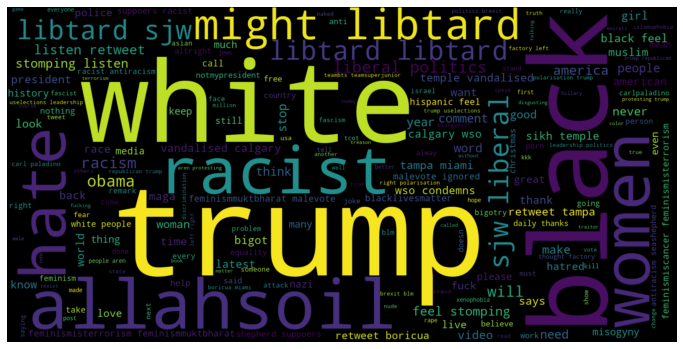

In [ ]:
import matplotlib.pyplot as plt

neg_tweets = training[training.label == 1]
neg_string = []
for t in neg_tweets.tweet:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=300).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_text[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.14808416, -0.20216864, -0.32765266, -0.18243363,  0.11220028,
         0.16373754,  0.05628956, -0.22185096, -0.0747824 ,  0.18737426,
         0.16179842, -0.07205924, -0.00330262,  0.22917822, -0.3224408 ,
        -0.12975734,  0.19206089, -0.13658376,  0.00103353, -0.0485791 ,
         0.07119115,  0.06768534,  0.16105083, -0.1406542 ,  0.10837235,
         0.3301314 , -0.26210815, -0.06247202,  0.29410827, -0.07544945,
        -0.1321843 , -0.02131046,  0.04966639,  0.03409505, -0.27257788,
        -0.08586751,  0.2726697 ,  0.05651699, -0.21940647, -0.25224274,
         0.31677127, -0.04545145,  0.0384911 , -0.12849973,  0.13988742,
         0.08590916,  0.13431183, -0.01103316,  0.07414539, -0.41209972],
       [ 0.14021808, -0.16118526, -0.0319198 , -0.2634714 ,  0.0893983 ,
         0.05663258,  0.25570166,  0.2685329 , -0.27488115, -0.13529268,
        -0.09451762,  0.23651737, -0.02535236, -0.06197646, -0.12810369,
 

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

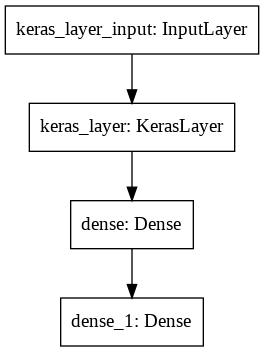

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
history = model.fit(train_text,train_labels,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
800/800 [==============================] - 26s 30ms/step - loss: 0.2858 - accuracy: 0.9233 - val_loss: 0.1377 - val_accuracy: 0.9496
Epoch 2/10
800/800 [==============================] - 23s 29ms/step - loss: 0.0916 - accuracy: 0.9669 - val_loss: 0.1342 - val_accuracy: 0.9543
Epoch 3/10
800/800 [==============================] - 23s 29ms/step - loss: 0.0456 - accuracy: 0.9843 - val_loss: 0.1579 - val_accuracy: 0.9534
Epoch 4/10
800/800 [==============================] - 23s 29ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.1968 - val_accuracy: 0.9537
Epoch 5/10
800/800 [==============================] - 23s 29ms/step - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.2357 - val_accuracy: 0.9514
Epoch 6/10
800/800 [==============================] - 24s 29ms/step - loss: 0.0082 - accuracy: 0.9979 - val_loss: 0.2693 - val_accuracy: 0.9499
Epoch 7/10
800/800 [==============================] - 23s 29ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.2971 - val_accuracy:

In [ ]:
#mount to google drive so we can save our model there
from google.colab import drive
drive.mount('/content/drive')
path = path = F"/content/drive/My Drive/Model_for_TwitterHateSpeechSentimentAnalysis" 

Mounted at /content/drive


In [ ]:
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Model_for_TwitterHateSpeechSentimentAnalysis/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Model_for_TwitterHateSpeechSentimentAnalysis/assets


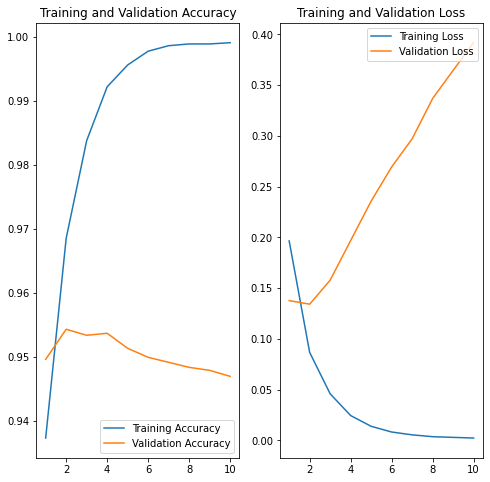

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#The next box contains VERY HATEFUL language! Please proceed at your own risk.

In [ ]:
import numpy as np
#these reviews were slapped right off of Rotten Tomatoes (so the model has no chance of having seen them). Try and guess which movie they came from!
hate_speech = ('exterminate ethnic-group')
non_hate_speech = ('diversity is good for schools')
def predicter(x):
  predictions = model.predict(np.array([x]))
  if predictions > 0:
    print("hateful")
  elif predictions< 1:
    print("not-hateful")
  
predicter(hate_speech)
predicter(non_hate_speech)

hateful
not-hateful
